In [6]:
import MeCab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import os
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

from sklearn.datasets import load_files

import lib.preprocesser as pre


In [88]:
import importlib
importlib.reload(pre)

<module 'lib.preprocesser' from '/Users/takizawatakafumi/code/ml_text_similarity/code/lib/preprocesser.py'>

In [53]:
dirlist = ["dokujo-tsushin","it-life-hack","kaden-channel","livedoor-homme",
           "movie-enter","peachy","smax","sports-watch","topic-news"]
color_list = ['red','orange','yellow','lime','green','cyan','navy','purple','pink','w','black']

In [3]:
#データ読み込み
df = pd.DataFrame(columns=["class","news"])

for i in tqdm(dirlist):
    path = "data/text/"+i+"/*.txt"
    files = glob.glob(path)
    files.pop()
    for j in tqdm(files):
        f = open(j)
        data = f.read() 
        f.close()
        t = pd.Series([i,"".join(data.split("\n")[3:])],index = df.columns)
        df  = df.append(t,ignore_index=True)

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [21]:
df['word_list'] = df['news'].map(pre.parse_text)

In [25]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [26]:
n_features = 1000
n_components = 10
n_top_words = 20

In [27]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,analyzer=pre.parse_text)
tfidf = tfidf_vectorizer.fit_transform(df['news'])

In [34]:
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 3.085s.


In [35]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: さん こと 人 いる 歳 女性 結婚 女 自分 私 男性 する 彼 ある 仕事 よう いい 恋愛 男 そう
Topic #1: - D . ドコモ S 搭載 モデル フォン 対応 スマート MAX 発売 GB Android , 発表 NTT ◯ | (
Topic #2: 映画 公開 作 作品 監督 本 月 日 映像 賞 世界 年 役 演じる 主演 する MOVIE たち いる 全国
Topic #3: ネット 掲示板 いる 声 番組 話題 批判 関連 記事 AKB 発言 られ 放送 情報 日 ツイッター する 氏 ) ニュース
Topic #4: 選手 試合 代表 戦 氏 日本 サッカー 監督 チーム 日 五輪 野球 放送 杯 W こと 番組 いる プロ する
Topic #5: する いる できる 話題 こと iPhone 機能 通 円 チェック サービス なる 利用 よう ある ビデオ 売れ筋 デジタル PC 製品
Topic #6: 応募 当選 プレゼント 様 賞品 発送 月 キャンペーン ください 名 日 いただき 了承 Peachy 肌 連絡 いたし 期間 年 場合
Topic #7: . アプリ / 画面 com Android :// タップ 表示 Google http S MAX エスマックス ゲーム する でき 紹介 iPhone カテゴリ
Topic #8: 更新 ソフトウェア ください アップデート 場合 ダウンロード 利用 設定 表示 データ 実施 中 操作 でき お客様 行う 電池 端末 する -
Topic #9: 韓国 日本 肌 日本人 いる 日 人 五輪 ネット 中国 関連 独 メディア 批判 国 記事 金 ニュース 意見 的



In [37]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (len(df['news'].values), n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=7358 and n_features=1000...
done in 9.481s.

Topics in LDA model:
Topic #0: SH AQUOS PHONE D バッテリー ISW 容量 ドコモ KDDI au ソフトバンク mAh 防水 スマートフォン N LTE 用 スマホ F ICS
Topic #1: さん 結婚 いる 女性 こと 歳 男性 自分 独 いい 生活 離婚 ない する 彼 とき 女 人 的 独身
Topic #2: さん 歳 結婚 こと エリア 女性 いる 自転車 占い 人 会社 韓国 する たち 自分 女 彼 ある 思っ 料理
Topic #3: いる こと する 日 人 さん 映画 日本 ネット なっ 氏 年 月 よう 女性 ある 掲示板 韓国 自分 選手
Topic #4: - . する アプリ / S こと MAX できる Android 機能 円 いる スマート iPhone 月 画面 フォン 発売 対応
Topic #5: 町 会議 さん 県 会場 コンテンツ 女 私 どこ 自転車 水 こと 女性 参加 できる いる 開催 全国 男 結婚
Topic #6: 孫 社長 Google ソフトバンク 見る 発言 ) Twitter ( 検索 理由 今日 . Amazon co 寄せ jp 言葉 グループ 氏
Topic #7: 通 デジ 書籍 デジタル 電子 スマート フォン アップル 機能 機器 Windows いる iPhone する 認識 サービス パソコン 皆さん 音声 ユーザー
Topic #8: バッテリー 充電 容量 mAh ケーブル 用 人 GALAXY iPad 内蔵 V ドコモ スマホ する 歳 いる こと D USB できる
Topic #9: 女 こと さん マーク 会議 ブック 私 恋愛 人 する 独 いる 子 男性 ニュース 生 自分 言う IT 情報



In [38]:
lda.transform(tfidf[0])

array([[0.01131872, 0.01131872, 0.01131872, 0.8981181 , 0.01132387,
        0.01132247, 0.01131889, 0.01132307, 0.01131872, 0.01131872]])

In [40]:
lda.transform(tfidf[1])

array([[0.01024289, 0.0102429 , 0.0102429 , 0.90781008, 0.01024489,
        0.0102429 , 0.01024376, 0.01024391, 0.0102429 , 0.0102429 ]])

In [41]:
vec_news_lda = lda.transform(tfidf)

In [79]:
type(vec_news_lda)

numpy.ndarray

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vec_pca = pca.fit_transform(vec_news_lda)

In [44]:
vec_pca

array([[-0.43199956, -0.0206796 ],
       [-0.43973019, -0.02521415],
       [-0.43012959, -0.0195824 ],
       ...,
       [-0.39373237,  0.00176619],
       [-0.41312032, -0.00956168],
       [-0.40812505, -0.00667455]])

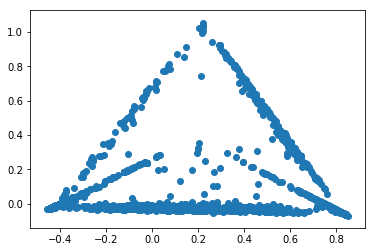

In [50]:
plt.scatter(vec_pca[:,0],vec_pca[:,1])

In [47]:
vec_pca[1,0]

-0.4397301907542892

In [51]:
from sklearn.manifold import TSNE
vec_tsne = TSNE(n_components=2).fit_transform(vec_news_lda) 

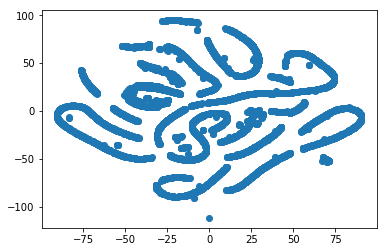

In [52]:
plt.scatter(vec_tsne[:,0],vec_tsne[:,1])

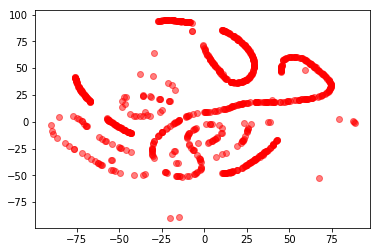

In [61]:
topic = 'dokujo-tsushin'
idx =  df['class'] == topic
plt.scatter(vec_tsne[idx,0],vec_tsne[idx,1],alpha=0.5,c=color_list[0],label=topic)

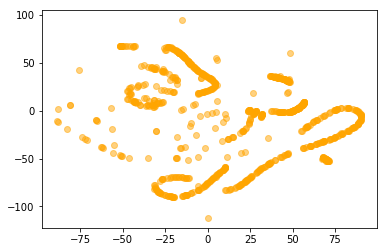

In [63]:
topic = dirlist[1]
idx =  df['class'] == topic
plt.scatter(vec_tsne[idx,0],vec_tsne[idx,1],alpha=0.5,c=color_list[1],label=topic)

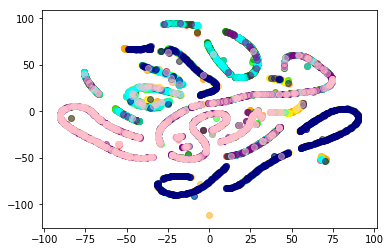

In [60]:
for i,topic in enumerate(dirlist):
    idx =  df['class'] == topic
    plt.scatter(vec_tsne[idx,0],vec_tsne[idx,1],alpha=0.5,c=color_list[i],label=topic)

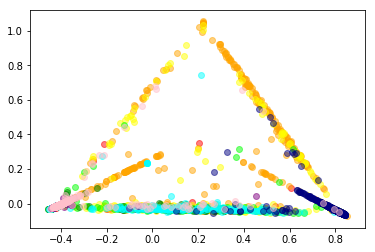

In [59]:
for i,topic in enumerate(dirlist):
    idx =  df['class'] == topic
    plt.scatter(vec_pca[idx,0],vec_pca[idx,1],alpha=0.5,c=color_list[i],label=topic)

In [64]:
vec_nmf = nmf.transform(tfidf)

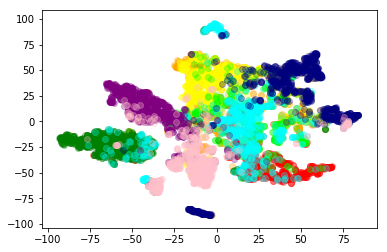

In [75]:
vec_nmf_tsne = TSNE(n_components=2).fit_transform(vec_nmf) 
for i,topic in enumerate(dirlist):
    idx =  df['class'] == topic
    plt.scatter(vec_nmf_tsne[idx,0],vec_nmf_tsne[idx,1],alpha=0.3,c=color_list[i],label=topic)

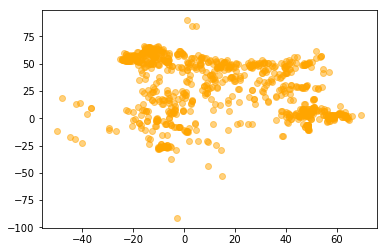

In [78]:
topic_num = 1
topic = dirlist[topic_num]
idx =  df['class'] == topic
plt.scatter(vec_nmf_tsne[idx,0],vec_nmf_tsne[idx,1],alpha=0.5,c=color_list[topic_num],label=topic)

In [81]:
from gensim.models import word2vec
import logging
model_name = "./model/200features_20minwords_10context_len2alldata.model"
model = word2vec.Word2Vec.load(model_name)

In [83]:
model.wv.vocab

{'マジ': <gensim.models.keyedvectors.Vocab at 0x12a6be240>,
 'カウンセラー': <gensim.models.keyedvectors.Vocab at 0x12a376f98>,
 '従業': <gensim.models.keyedvectors.Vocab at 0x12b416fd0>,
 '声援': <gensim.models.keyedvectors.Vocab at 0x1182e99e8>,
 'しなやか': <gensim.models.keyedvectors.Vocab at 0x12b6020f0>,
 '対峙': <gensim.models.keyedvectors.Vocab at 0x12b40d8d0>,
 'シック': <gensim.models.keyedvectors.Vocab at 0x12b41a390>,
 '付き合い': <gensim.models.keyedvectors.Vocab at 0x1183b9eb8>,
 '質疑': <gensim.models.keyedvectors.Vocab at 0x12b1a3eb8>,
 '真っ先': <gensim.models.keyedvectors.Vocab at 0x12a6a8a58>,
 '不審': <gensim.models.keyedvectors.Vocab at 0x12a40c5f8>,
 'プロジェクター': <gensim.models.keyedvectors.Vocab at 0x118303278>,
 '大使館': <gensim.models.keyedvectors.Vocab at 0x12a57b208>,
 '皮肉': <gensim.models.keyedvectors.Vocab at 0x12b1c6ac8>,
 '敗': <gensim.models.keyedvectors.Vocab at 0x11833a828>,
 '荒れ': <gensim.models.keyedvectors.Vocab at 0x118308ac8>,
 'アリス': <gensim.models.keyedvectors.Vocab at 0x12b41f7b8>

In [94]:
tv = pre.Text_Vectornizer(model)
vec_text = np.array(tv.transform(df['news'].values) )

In [95]:
vec_text.shape

(7358, 200)

In [110]:
vec_text_tsne = TSNE(n_components=2).fit_transform(vec_text) 

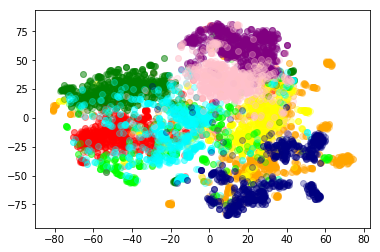

In [111]:
for i,topic in enumerate(dirlist):
    idx =  df['class'] == topic
    plt.scatter(vec_text_tsne[idx,0],vec_text_tsne[idx,1],alpha=0.3,c=color_list[i],label=topic)

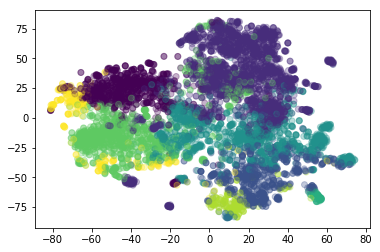

In [131]:
idx = 
plt.scatter(vec_text_tsne[:,0],vec_text_tsne[:,1],alpha=0.3,c=cluster_labels)

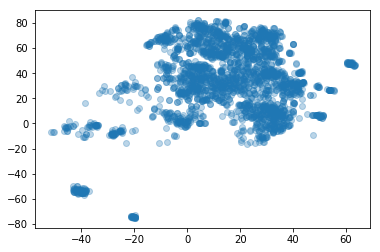

In [134]:
idx = cluster_labels == 1
plt.scatter(vec_text_tsne[idx,0],vec_text_tsne[idx,1],alpha=0.3)

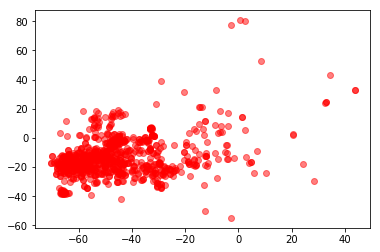

In [123]:
topic_num = 0
topic = dirlist[topic_num]
idx =  df['class'] == topic
plt.scatter(vec_text_tsne[idx,0],vec_text_tsne[idx,1],alpha=0.5,c=color_list[topic_num],label=topic)

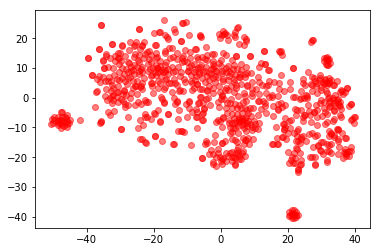

In [122]:
topic_num = 0
topic = dirlist[topic_num]
idx =  df['class'] == topic
text_tsne_topic = TSNE(n_components=2).fit_transform(vec_text[idx,:])
plt.scatter(text_tsne_topic[:,0],text_tsne_topic[:,1],alpha=0.5,c=color_list[topic_num],label=topic)

In [130]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=9)
cluster_labels = gmm.fit(vec_text).predict(vec_text)

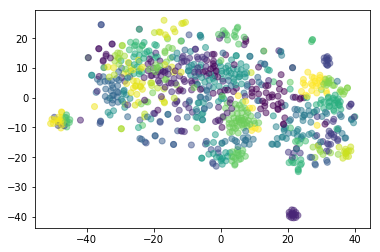

In [129]:
plt.scatter(text_tsne_topic[:,0],text_tsne_topic[:,1],alpha=0.5,c=cluster_labels)